# 1. Data Analysis and Pre- Processing 

## Data Analysis

In [1]:
! ls /home/aekanun/input/chest_xray/train/NORMAL/*.jpeg | wc -l

1349


In [2]:
! ls /home/aekanun/input/chest_xray/train/PNEUMONIA/*.jpeg | wc -l

3883


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt #Ploting charts
from glob import glob #retriving an array of files in directories
from keras.models import Sequential #for neural network models
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator #Data augmentation and preprocessing
from keras.utils import to_categorical #For One-hot Encoding
from keras.optimizers import Adam, SGD, RMSprop #For Optimizing the Neural Network
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
/home/aekanun/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
#Checking datasets
import os
paths = os.listdir(path="./input")
print(paths)

['chest_xray']


In [5]:
path_train = "./input/chest_xray/train"
path_val = "./input/chest_xray/val"
path_test = "./input/chest_xray/test"

### A sample of Pneumonia

In [6]:
img = glob(path_train+"/PNEUMONIA/*.jpeg") #Getting all images in this folder

In [7]:
img = np.asarray(plt.imread(img[0]))

In [8]:
plt.get_backend()

'module://ipykernel.pylab.backend_inline'

In [9]:
plt.imshow(img)

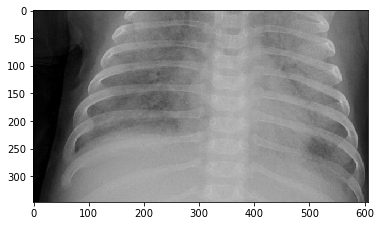

In [10]:
plt.show()

In [11]:
img.shape

(347, 607, 3)

### A sample of Normal

In [12]:
img = glob(path_train+"/NORMAL/*.jpeg") #Getting all images in this folder

In [13]:
img = np.asarray(plt.imread(img[0]))

In [14]:
plt.imshow(img)

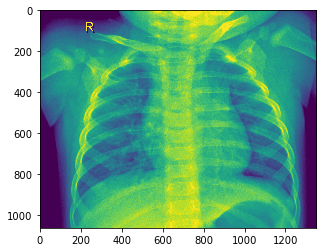

In [15]:
plt.show()

In [16]:
img.shape

(1062, 1350)

## Data Preprocessing

In [17]:
from pyspark.serializers import PickleSerializer

In [18]:
spark = SparkSession.builder.master("yarn").appName("AppName").\
config("spark.serializer","PickleSerializer").\
config("spark.driver.maxResultSize", "7g").\
getOrCreate()

In [19]:
normal_files = !ls /home/aekanun/input/chest_xray/train/NORMAL/*.jpeg

In [20]:
pneumonia_files = !ls /home/aekanun/input/chest_xray/train/PNEUMONIA/*.jpeg

In [21]:
from pyspark.sql.functions import lit
from sparkdl.image import imageIO
import pyspark.ml.linalg as spla
import pyspark.sql.types as sptyp
import numpy as np

def CreateTrainImageUriandLabels(image_uris, label, cardinality):
  # Create image categorical labels (integer IDs)
  local_rows = []
  for uri in image_uris:
    label_inds = np.zeros(cardinality)
    label_inds[label] = 1.0
    one_hot_vec = spla.Vectors.dense(label_inds.tolist())
    _row_struct = {"uri": uri, "one_hot_label": one_hot_vec, "label": float(label)}
    row = sptyp.Row(**_row_struct)
    local_rows.append(row)

  image_uri_df = sqlContext.createDataFrame(local_rows)
  return image_uri_df

In [22]:
label_cardinality = 2

In [23]:
normal_uri_df = CreateTrainImageUriandLabels(normal_files,0,label_cardinality)

In [24]:
normal_uri_df.count()

1349

In [25]:
pneumonia_uri_df = CreateTrainImageUriandLabels(pneumonia_files,1,label_cardinality)

In [26]:
pneumonia_uri_df.count()

3883

In [27]:
normal_train, normal_test, _ = normal_uri_df.randomSplit([0.002, 0.02, 0.99])

In [28]:
pneumonia_train, pneumonia_test, _ = pneumonia_uri_df.randomSplit([0.002, 0.02, 0.99])

In [29]:
normal_train.count()

0

In [30]:
#normal_train.take(1)

In [31]:
pneumonia_train.count()

7

In [32]:
#pneumonia_train.take(10)

In [33]:
train_df = normal_train.unionAll(pneumonia_train)
test_df = normal_test.unionAll(pneumonia_test)

In [34]:
train_df.count()

7

In [35]:
train_df = train_df.repartition(20000)
test_df = test_df.repartition(20000)

# 2. Customize Layers in Keras

In [36]:
! rm -rf *.h5

In [37]:
#Import all modules and Define a function that can be useful to make data preprocessing
import PIL.Image
import numpy as np
from keras.applications.imagenet_utils import preprocess_input

def load_image_from_uri(local_uri):
  img = (PIL.Image.open(local_uri).convert('RGB').resize((226, 226), PIL.Image.ANTIALIAS))
  img_arr = np.array(img).astype(np.float32)
  img_tnsr = preprocess_input(img_arr[np.newaxis, :])
  return img_tnsr

In [38]:
#Import Keras Model and Customize it with Keras Layers
from keras.layers import Activation, Dense, Flatten
from keras.models import Sequential

model = Sequential()
model.add(Flatten(input_shape=(226, 226, 3)))
model.add(Dense(2))
model.add(Activation("softmax"))
model.save('model-small.h5')  # saves to the local filesystem

In [39]:
! ls -lh *.h5

-rw-rw-r-- 1 aekanun aekanun 1.2M Aug  6 03:07 model-small.h5


### Recheck everything that is pre-defined.

In [40]:
train_df.printSchema()

root
 |-- label: double (nullable = true)
 |-- one_hot_label: vector (nullable = true)
 |-- uri: string (nullable = true)



In [41]:
from pyspark.sql.functions import col

In [42]:
train_df.select('one_hot_label','label','uri').filter(col('label') == 1.0).take(1)

[Row(one_hot_label=DenseVector([0.0, 1.0]), label=1.0, uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person1203_bacteria_3155.jpeg')]

In [43]:
train_df.select('one_hot_label','label','uri').filter(col('label') == 0.0).take(1)

[]

In [44]:
! ls -l /home/aekanun/*.h5

-rw-rw-r-- 1 aekanun aekanun 1238064 Aug  6 03:07 /home/aekanun/model-small.h5


In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 153228)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 306458    
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 306,458
Trainable params: 306,458
Non-trainable params: 0
_________________________________________________________________


# 3. Develop a pipeline of model construction

In [46]:
from sparkdl.estimators.keras_image_file_estimator import KerasImageFileEstimator

#dbutils.fs.cp(dbfs_model_small_path, 'file:/tmp/model-small-tmp.h5')
estimator = KerasImageFileEstimator(inputCol="uri",
                                    outputCol="prediction",
                                    labelCol="one_hot_label",
                                    imageLoader=load_image_from_uri,
                                    kerasOptimizer='adam',
                                    kerasLoss='categorical_crossentropy',
                                    modelFile='/home/aekanun/model-small.h5')

In [47]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

In [48]:
sc.serializer

AutoBatchedSerializer(PickleSerializer())

In [49]:
sc.serializer.bestSize

65536

# 4. Train a CNN using Distributed Deep Learning

### Fit training set to the Customized Keras Model with Hyperparameter Tunning and Cross Validation.

In [50]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = (
  ParamGridBuilder()
  .addGrid(estimator.kerasFitParams, [{"batch_size": 16, "verbose": 0},
                                      {"batch_size": 16, "verbose": 0},
                                      {"initial_epoch":0},
                                      {"epochs":1}])
  .build()
)
mc = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label" )
cv = CrossValidator(estimator=estimator, estimatorParamMaps=paramGrid, evaluator=mc, numFolds=2)

cvModel = cv.fit(train_df)

INFO:tensorflow:Froze 2 variables.


/home/aekanun/.local/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Converted 2 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.
INFO:tensorflow:Froze 2 variables.
Conver

# 5. Model Evaluation with Testing Set

In [51]:
cvModel

CrossValidatorModel_27ab729702d7

In [52]:
mc.evaluate(cvModel.transform(test_df))

INFO:tensorflow:Froze 2 variables.


/home/aekanun/.local/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Converted 2 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


0.4296875

In [53]:
performance_df = cvModel.transform(test_df)

INFO:tensorflow:Froze 2 variables.


/home/aekanun/.local/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Converted 2 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [54]:
performance_df

DataFrame[label: double, one_hot_label: vector, uri: string, prediction: vector]

In [55]:
performance_df.select(['uri','label','one_hot_label','prediction']).filter(col('uri').like('%NORMAL%')).take(10)

[Row(uri='/home/aekanun/input/chest_xray/train/NORMAL/NORMAL2-IM-0418-0001.jpeg', label=0.0, one_hot_label=DenseVector([1.0, 0.0]), prediction=DenseVector([1.0, 0.0])),
 Row(uri='/home/aekanun/input/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg', label=0.0, one_hot_label=DenseVector([1.0, 0.0]), prediction=DenseVector([1.0, 0.0])),
 Row(uri='/home/aekanun/input/chest_xray/train/NORMAL/IM-0551-0001.jpeg', label=0.0, one_hot_label=DenseVector([1.0, 0.0]), prediction=DenseVector([0.0, 1.0])),
 Row(uri='/home/aekanun/input/chest_xray/train/NORMAL/IM-0528-0001.jpeg', label=0.0, one_hot_label=DenseVector([1.0, 0.0]), prediction=DenseVector([1.0, 0.0])),
 Row(uri='/home/aekanun/input/chest_xray/train/NORMAL/IM-0641-0001.jpeg', label=0.0, one_hot_label=DenseVector([1.0, 0.0]), prediction=DenseVector([0.0, 1.0])),
 Row(uri='/home/aekanun/input/chest_xray/train/NORMAL/IM-0714-0001.jpeg', label=0.0, one_hot_label=DenseVector([1.0, 0.0]), prediction=DenseVector([1.0, 0.0])),
 Row(uri='/home/aekan

# True Negative (Normal, and also predict Normal)

In [56]:
img = glob(path_train+"/NORMAL/NORMAL2-IM-1135-0001.jpeg") 

In [57]:
img = np.asarray(plt.imread(img[0]))

In [58]:
plt.imshow(img)

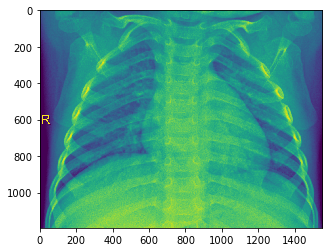

In [59]:
plt.show()

# False Positive (Normal, but predict Pneumonia)

In [60]:
img = glob(path_train+"/NORMAL/NORMAL2-IM-1330-0001.jpeg") 

In [61]:
img = np.asarray(plt.imread(img[0]))

In [62]:
plt.imshow(img)

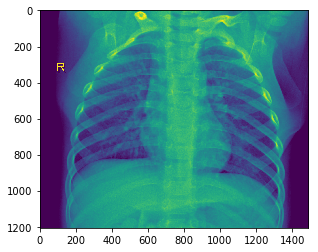

In [63]:
plt.show()

In [64]:
performance_df.select(['uri','label','one_hot_label','prediction']).filter(col('uri').like('%PNEUMONIA%')).take(10)

[Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person1911_bacteria_4815.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([1.0, 0.0])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person1607_virus_2785.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([1.0, 0.0])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person277_bacteria_1302.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([1.0, 0.0])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person1176_virus_1996.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([1.0, 0.0])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person1053_bacteria_2987.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([1.0, 0.0])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person1099_bacteria_3040.jpeg', label=1.0, one_hot_label=DenseVector([

# False Negative (Pneumonia but predict Normal)

In [65]:
img = glob(path_train+"/PNEUMONIA/person30_bacteria_148.jpeg") 

In [66]:
img = np.asarray(plt.imread(img[0]))

In [67]:
plt.imshow(img)

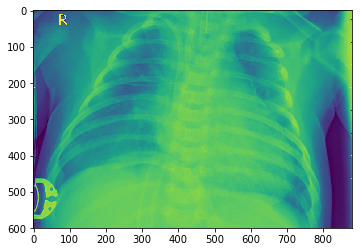

In [68]:
plt.show()

In [69]:
from pyspark.sql.functions import col

In [70]:
from pyspark.mllib.linalg import DenseVector

In [71]:
pneumonia_train.take(1)

[Row(label=1.0, one_hot_label=DenseVector([0.0, 1.0]), uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person112_virus_213.jpeg')]

In [72]:
normal_train.take(1)

[]